In [1]:
import torch
import torch .nn as nn
import torch . optim as optim
from torch . utils . data import DataLoader
import torchvision . transforms as transforms
import torchvision . datasets as datasets

In [68]:
from minisom import MiniSom

In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

Is CUDA supported by this system? True
CUDA version: 12.8


In [3]:
from sklearn.manifold import TSNE
import seaborn as sns

In [64]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_size=64):  
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7), 
            nn.ReLU()
        )
        self.fc_encode = nn.Linear(64 * 1 * 1, latent_size)
        # Decoder
        self.fc_decode = nn.Linear(latent_size, 64 * 1 * 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Tanh()
        )

    def forward(self, x):
        encoded_conv = self.encoder(x)
        encoded_flat = encoded_conv.view(encoded_conv.size(0), -1)
        latent = self.fc_encode(encoded_flat)
        decoded_flat = self.fc_decode(latent)
        decoded_conv_input = decoded_flat.view(decoded_flat.size(0), 64, 1, 1)
        reconstructed = self.decoder(decoded_conv_input)
        return reconstructed, latent

In [57]:
latent_size = 64
learning_rate = 0.001
batch_size = 64
epochs = 20
num_clusters = 10

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = ConvAutoencoder(latent_size=latent_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
model.train()
for epoch in range(epochs):
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed, _ = model(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.1544
Epoch [2/20], Loss: 0.0568
Epoch [3/20], Loss: 0.0419
Epoch [4/20], Loss: 0.0371
Epoch [5/20], Loss: 0.0343
Epoch [6/20], Loss: 0.0321
Epoch [7/20], Loss: 0.0308
Epoch [8/20], Loss: 0.0300
Epoch [9/20], Loss: 0.0292
Epoch [10/20], Loss: 0.0281
Epoch [11/20], Loss: 0.0275
Epoch [12/20], Loss: 0.0271
Epoch [13/20], Loss: 0.0264
Epoch [14/20], Loss: 0.0257
Epoch [15/20], Loss: 0.0253
Epoch [16/20], Loss: 0.0250
Epoch [17/20], Loss: 0.0248
Epoch [18/20], Loss: 0.0246
Epoch [19/20], Loss: 0.0245
Epoch [20/20], Loss: 0.0243


In [ ]:
model.eval()
embeddings = []
labels = [] 
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        _, latent = model(data) 
        embeddings.append(latent.cpu().numpy())
        labels.append(target.numpy())

embeddings = np.concatenate(embeddings, axis=0)
true_labels = np.concatenate(labels, axis=0) 

In [79]:
kmeans = KMeans(n_clusters=num_clusters, n_init=20, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)
kmeans_sil_score = silhouette_score(embeddings, kmeans_labels)
kmeans_db_score = davies_bouldin_score(embeddings, kmeans_labels)
kmeans_ch_score = calinski_harabasz_score(embeddings, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_sil_score:.4f}")
print(f"K-Means Davies-Bouldin Index: {kmeans_db_score:.4f}")
print(f"K-Means Calinski-Harabasz Index: {kmeans_ch_score:.4f}")

K-Means Silhouette Score: 0.1320
K-Means Davies-Bouldin Index: 1.9907
K-Means Calinski-Harabasz Index: 763.2745


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


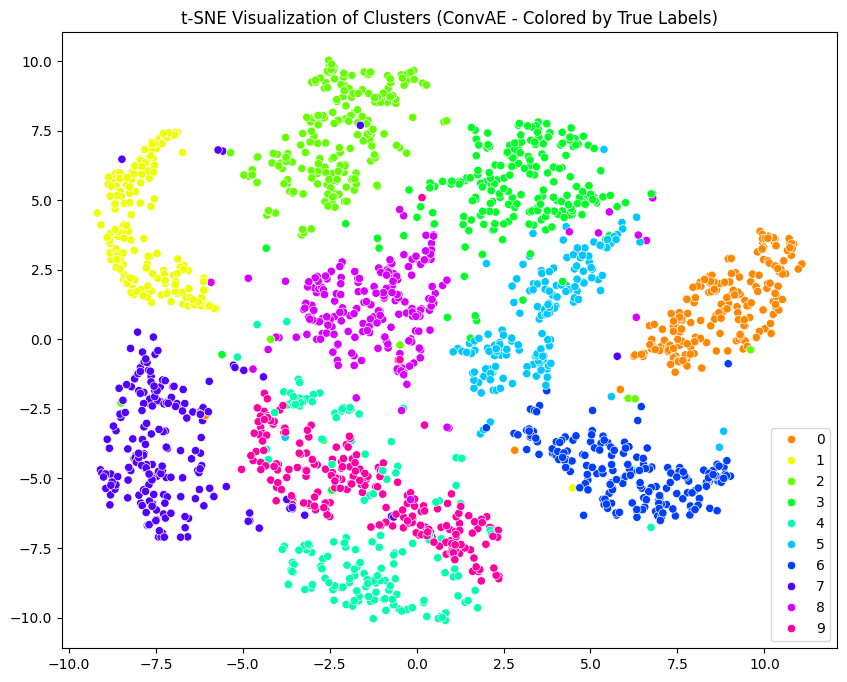

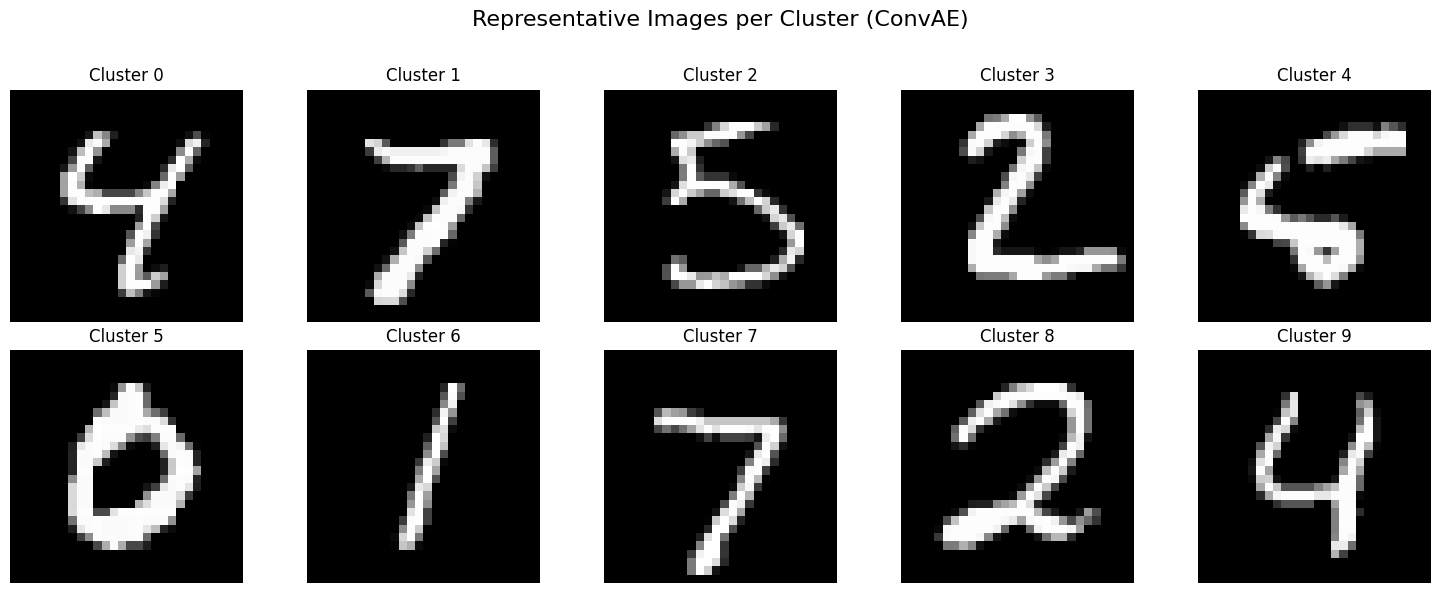

In [ ]:
num_samples_for_tsne = 2000
tsne_indices = np.random.choice(len(embeddings), num_samples_for_tsne, replace=False)
tsne_embeddings = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300).fit_transform(embeddings[tsne_indices])
tsne_cluster_labels = cluster_labels[tsne_indices]


plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=true_labels[tsne_indices], palette=sns.color_palette("hsv", num_clusters), legend="full")
plt.title("t-SNE Visualization of Clusters (ConvAE - Colored by True Labels)")
plt.savefig("mnist_clusters_tsne_convae_true_labels.png")
plt.show()
plt.close()

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Representative Images per Cluster (ConvAE)", fontsize=16)
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    if len(cluster_indices) > 0:
        img_idx_in_test_dataset = cluster_indices[0]
        img_tensor = test_dataset[img_idx_in_test_dataset][0] 
        img_display = img_tensor.squeeze().cpu().numpy() * 0.5 + 0.5
        ax[i // 5, i % 5].imshow(img_display, cmap='gray')
        ax[i // 5, i % 5].set_title(f'Cluster {i}')
        ax[i // 5, i % 5].axis('off')
    else:
        ax[i // 5, i % 5].set_title(f'Cluster {i} (empty)')
        ax[i // 5, i % 5].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.savefig("mnist_cluster_representatives_convae.png")
plt.show()
plt.close()


In [ ]:
som_grid_size = (10, 10)  
som_sigma = 1.0
som_learning_rate = 0.5
som_iterations = 1000

In [ ]:
model.eval()
embeddings = []
true_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        _, latent = model(data)
        embeddings.append(latent.cpu().numpy())
        true_labels.append(target.numpy())
embeddings = np.concatenate(embeddings, axis=0)
true_labels = np.concatenate(true_labels, axis=0)


embeddings_normalized = (embeddings - embeddings.mean(axis=0)) / (embeddings.std(axis=0) + 1e-8)

In [ ]:
som = MiniSom(som_grid_size[0], som_grid_size[1], latent_size, sigma=som_sigma, learning_rate=som_learning_rate)
som.random_weights_init(embeddings_normalized)
som.train_random(embeddings_normalized, som_iterations)


som_labels = np.array([som.winner(x)[0] * som_grid_size[1] + som.winner(x)[1] for x in embeddings_normalized])
unique_som_labels = np.unique(som_labels)


if len(unique_som_labels) > num_clusters:
    from sklearn.cluster import KMeans
    som_weights = som.get_weights().reshape(-1, latent_size)
    kmeans_som = KMeans(n_clusters=num_clusters, n_init=20, random_state=42)
    som_cluster_labels = kmeans_som.fit_predict(som_weights)
    neuron_to_cluster = {i: som_cluster_labels[i] for i in range(len(som_cluster_labels))}
    cluster_labels = np.array([neuron_to_cluster[label] for label in som_labels])
else:
    cluster_labels = som_labels
    if len(unique_som_labels) < num_clusters:
        print(f"Warning: SOM produced {len(unique_som_labels)} clusters. Applying K-Means fallback.")
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=num_clusters, n_init=20, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings_normalized)
if len(np.unique(cluster_labels)) > 1:
    sil_score = silhouette_score(embeddings_normalized, cluster_labels)
    db_score = davies_bouldin_score(embeddings_normalized, cluster_labels)
    ch_score = calinski_harabasz_score(embeddings_normalized, cluster_labels)
    print(f"MiniSOM Silhouette Score: {sil_score:.4f}")
    print(f"MiniSOM Davies-Bouldin Index: {db_score:.4f}")
    print(f"MiniSOM Calinski-Harabasz Index: {ch_score:.4f}")
else:
    print("Error: Insufficient clusters for metric calculation.")


unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
print(f"Cluster Distribution: {dict(zip(unique_clusters, counts))}")


unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
print(f"Cluster Distribution: {dict(zip(unique_clusters, counts))}")


tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings[:1000])
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=cluster_labels[:1000], palette="deep")
plt.title("t-SNE Visualization of MiniSOM Clusters (MNIST)")
plt.savefig("mnist_som_clusters_tsne.png")
plt.close()

MiniSOM Silhouette Score: 0.0854
MiniSOM Davies-Bouldin Index: 2.6282
MiniSOM Calinski-Harabasz Index: 527.8372
Cluster Distribution: {0: 1157, 1: 1617, 2: 706, 3: 787, 4: 769, 5: 1467, 6: 1140, 7: 806, 8: 803, 9: 748}
Cluster Distribution: {0: 1157, 1: 1617, 2: 706, 3: 787, 4: 769, 5: 1467, 6: 1140, 7: 806, 8: 803, 9: 748}


In [74]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings[:1000])
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=cluster_labels[:1000], palette="deep")
plt.title("t-SNE Visualization of MiniSOM Clusters (MNIST)")
plt.savefig("mnist_som_clusters_tsne.png")
plt.close()